In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error
import numpy as np

In [ ]:
df= pd.read_csv ('../data/raw/medical_insurance_cost.csv.csv')
print("Primeras filas:")
print(df.head())

print("\nInformación del dataset:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

print("\nValores nulos:")
print(df.isnull().sum())

Primeras filas:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Estadísticas descriptivas:
               age   

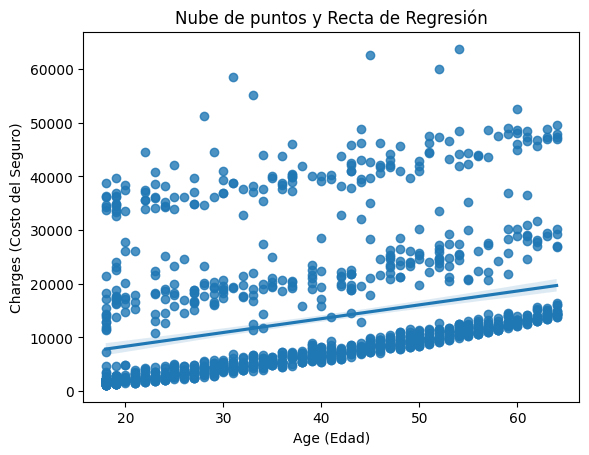

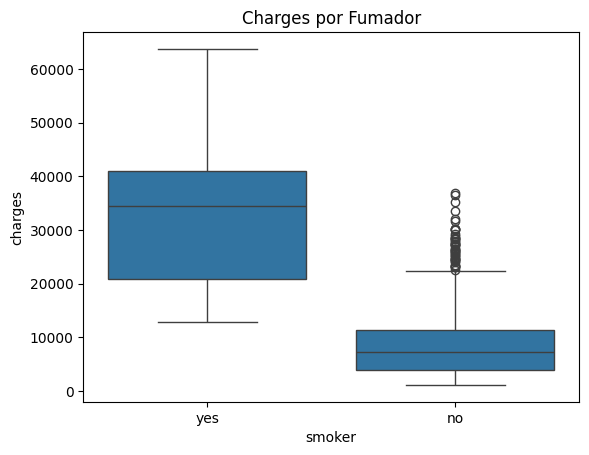


Correlación con charges:
charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64


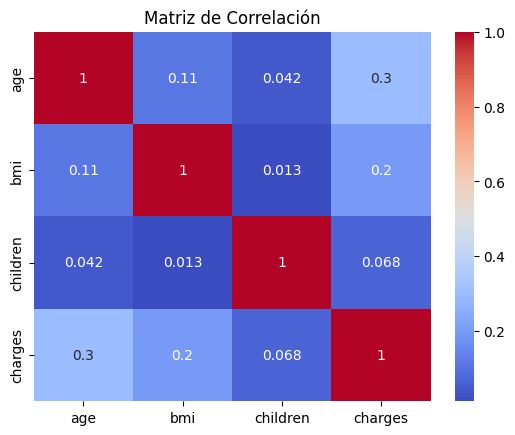

In [3]:
#VISUALIZACION

sns.regplot(x="age", y="charges", data=df)
plt.title("Nube de puntos y Recta de Regresión")
plt.xlabel("Age (Edad)")
plt.ylabel("Charges (Costo del Seguro)")
plt.show()

# Boxplot por fumador (variable MÁS importante)
sns.boxplot(x='smoker', y='charges', data=df)
plt.title("Charges por Fumador")
plt.show()

# Matriz de correlación
correlacion = df[['age', 'bmi', 'children', 'charges']].corr()
print("\nCorrelación con charges:")
print(correlacion['charges'].sort_values(ascending=False))

sns.heatmap(correlacion, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

In [5]:
# Convertir variables categóricas a numéricas
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

print("\nColumnas después de codificar:")
print(df_encoded.columns.tolist())

X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# División train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTamaño train: {len(X_train)}")
print(f"Tamaño test: {len(X_test)}")

# Escalamos los datos con StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


Columnas después de codificar:
['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']

Tamaño train: 1070
Tamaño test: 268


In [6]:
def get_metrics(yhat, y_test, yhat_train, y_train):
    metrics_train = r2_score(y_train, yhat_train), median_absolute_error(y_train, yhat_train), mean_absolute_percentage_error(y_train, yhat_train)*100
    metrics_test = r2_score(y_test, yhat), median_absolute_error(y_test, yhat), mean_absolute_percentage_error(y_test, yhat)*100
    metrics_diff = list(map(lambda x: x[1]-x[0], zip(metrics_train, metrics_test)))
    return pd.DataFrame(data=[metrics_train, metrics_test, metrics_diff], columns=['R2', 'Median AE', 'MAPE'], index=['Train set', 'Test set', 'Diferencia'])

In [7]:
m_linear = LinearRegression().fit(X_train_sc, y_train)

# Predicciones
yhat_train_linear = m_linear.predict(X_train_sc)
yhat_linear = m_linear.predict(X_test_sc)

# Métricas
print("\nMétricas del modelo:")
print(get_metrics(yhat_linear, y_test, yhat_train_linear, y_train))


Métricas del modelo:
                  R2    Median AE       MAPE
Train set   0.741726  2445.160412  42.202685
Test set    0.783593  2695.139463  46.888256
Diferencia  0.041867   249.979051   4.685571


In [8]:
#ANALISIS RESIDUOS
residuos = y_test - yhat_linear

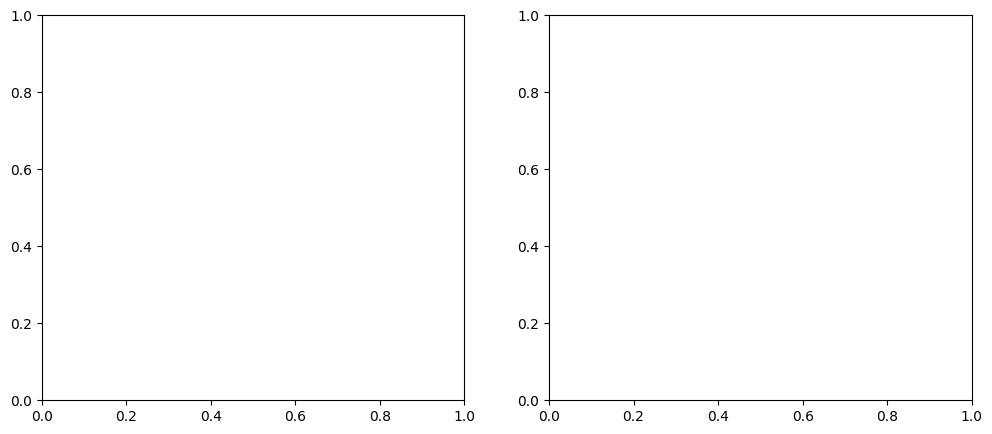

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

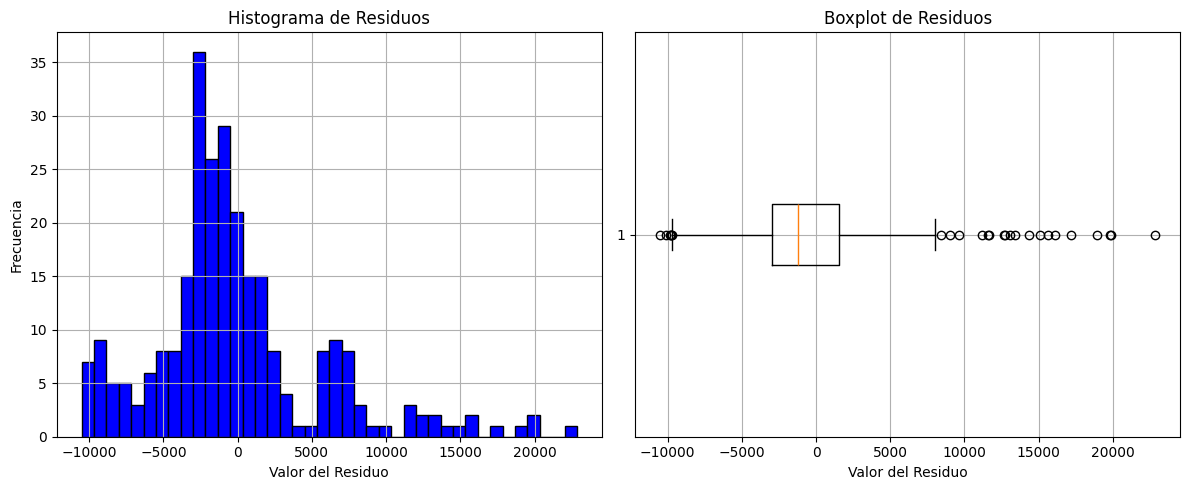

In [16]:
residuos = y_test - yhat_linear

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(residuos, bins=40, color='blue', edgecolor='black')
ax1.set_title('Histograma de Residuos')
ax1.set_xlabel('Valor del Residuo')
ax1.set_ylabel('Frecuencia')
ax1.grid(True)

ax2.boxplot(residuos, vert=False)
ax2.set_title('Boxplot de Residuos')
ax2.set_xlabel('Valor del Residuo')
ax2.grid(True)

plt.tight_layout()
plt.show()



Métricas del modelo Lasso:
                  R2    Median AE       MAPE
Train set   0.741067  2453.678137  42.226651
Test set    0.780632  2653.275654  48.145522
Diferencia  0.039565   199.597517   5.918871


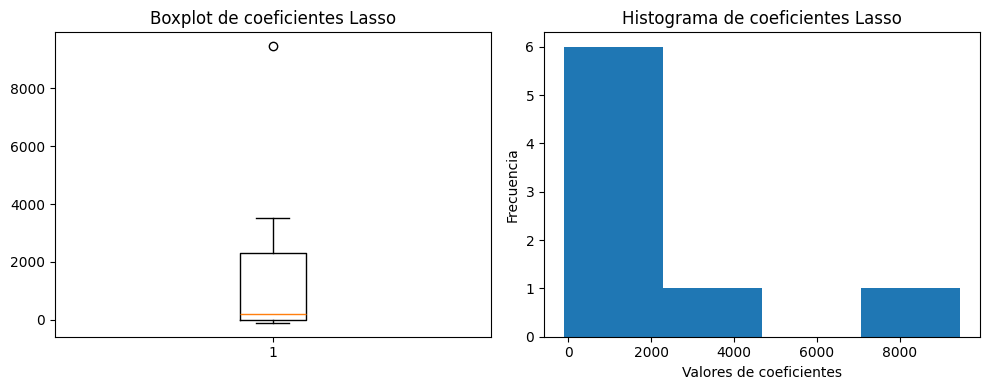


Porcentaje de variables canceladas: 25.0%
El modelo utiliza 6 variables.


In [13]:
#LASSO

m_lasso = LassoCV(alphas=np.logspace(-6, 6, 10), cv=5, random_state=42, n_jobs=-1).fit(X_train_sc, y_train)

# Predicciones
yhat_train_lasso = m_lasso.predict(X_train_sc)
yhat_lasso = m_lasso.predict(X_test_sc)

# Métricas
print("\nMétricas del modelo Lasso:")
print(get_metrics(yhat_lasso, y_test, yhat_train_lasso, y_train))

# Gráfico de coeficientes (ESTILO PROFESOR)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_lasso.coef_)
plt.title('Boxplot de coeficientes Lasso')

plt.subplot(1, 2, 2)
plt.hist(m_lasso.coef_, 'sturges')
plt.xlabel('Valores de coeficientes')
plt.ylabel('Frecuencia')
plt.title('Histograma de coeficientes Lasso')
plt.tight_layout()
plt.show()

# Variables canceladas
print(f'\nPorcentaje de variables canceladas: {round(len(m_lasso.coef_[np.abs(m_lasso.coef_)==0])/len(m_lasso.coef_)*100,2)}%')
print(f'El modelo utiliza {len(m_lasso.coef_[np.abs(m_lasso.coef_)>0])} variables.')


Métricas del modelo Ridge:
                  R2    Median AE       MAPE
Train set   0.741711  2448.227231  42.328155
Test set    0.783342  2708.013752  47.086404
Diferencia  0.041631   259.786521   4.758249


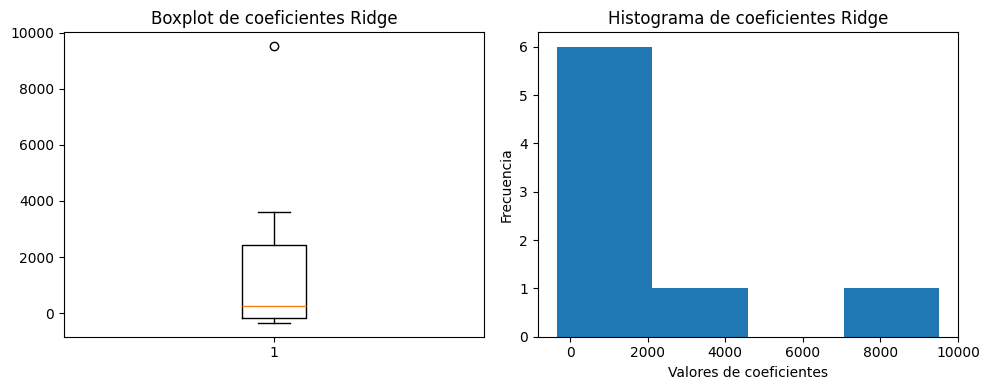

In [14]:
#RIDGE

m_ridge = RidgeCV(alphas=np.logspace(-6, 6, 10), cv=5).fit(X_train_sc, y_train)

# Predicciones
yhat_train_ridge = m_ridge.predict(X_train_sc)
yhat_ridge = m_ridge.predict(X_test_sc)

# Métricas
print("\nMétricas del modelo Ridge:")
print(get_metrics(yhat_ridge, y_test, yhat_train_ridge, y_train))

# Gráfico de coeficientes Ridge
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(m_ridge.coef_)
plt.title('Boxplot de coeficientes Ridge')

plt.subplot(1, 2, 2)
plt.hist(m_ridge.coef_, 'sturges')
plt.xlabel('Valores de coeficientes')
plt.ylabel('Frecuencia')
plt.title('Histograma de coeficientes Ridge')
plt.tight_layout()
plt.show()

In [15]:
# Comparación de R2 en test
print("\nR² en Test Set:")
print(f"Linear: {r2_score(y_test, yhat_linear):.4f}")
print(f"Lasso:  {r2_score(y_test, yhat_lasso):.4f}")
print(f"Ridge:  {r2_score(y_test, yhat_ridge):.4f}")


R² en Test Set:
Linear: 0.7836
Lasso:  0.7806
Ridge:  0.7833
